You've arrived at your destination and are looking forward to seeing the site. But it's a large site and you'll need a guide.

Each guide posts the route they'll take on a board, described the by steps they'll take. The steps are either `F` (take a step forward), `L` (turn left 90⁰ then take a step forward) or `R` (turn right 90⁰ then take a step forward). For example, the route `FFRRFLRRFR` will look like this (assuming you start facing right; the blob shows the starting point):


![Sample valid tour](question-example-tour-000-s0010-m000-trim.png)

A sample valid tour

while the tour `FFLLRLRLLFLR` looks like this (again, assuming you start facing right):

![Sample valid tour](question-example-tour-001-s0012-m000-trim.png) 

A sample valid tour

However, some of the tour guides are charlatans. They have tour that either doesn't return you to your starting place, or loops around to visit the same place more than once. For example, the tour `RRFFLLFFFFLF` doesn't return to your starting place:

![Sample invalid tour](question-example-tour-002-s0012-m001-trim.png)

An invalid tour

and the tour `RRLLRRFFRFRFLR` may get you back to where you started, but only after going around a small loop:

![Sample invalid tour](question-example-tour-003-s0014-m001-trim.png)

A sample invalid tour

You're only interested in valid tours, the ones that return you to your starting place and don't visit any other spot more than once. (It doesn't matter what direction you're facing when you return to your starting place, just that you return there at the end of the tour.)

In fact, you've got your daily fitness tracker widget to keep happy. Even on holiday, you need to keep up the number of steps you take. You're interested in the total length of all the valid tours. In the examples here, the total length of the two valid tours is 10 + 12 = 22 steps.

# Part 1

The tours are given in [06-tours.txt](06-tours.txt), one tour per line. 

What is the total length of all the valid tours?


It seems you've done your guides a disservice.

Yes, there are some charlatans around. But some of the tours a split between two guides. Each posted tour alone looks like it would be incomplete, but when you finish the first leg of a tour, you pick up a new guide and continue, eventually returning you to your starting place.

For instance, the tours `FFRFLLFFFRLRRFFFLFLRRFLLFFFFFRFLFFFFFRLLFRFRLLFFFFF` and `FLRFFRLLFRFFFLFFLFFRFRRLLFFRLFFFFFLLFFRFRFL` are both incomplete; on its own, each tour would leave you stranded. 

![A split tour](question-example-tour-004-s0051-m001-trim.png)

A split tour 

![More of a split tour](question-example-tour-005-s0043-m001-trim.png)

More of a split tour

But if you do one then the other, the complete 94-step tour is valid:

![Split tour combined](question-example-tour-006-s0094-m000-trim.png)

The split tour combined

(You start the second half of the tour heading left, so turn the second picture 180⁰ to visualise it.)

Luckily for you, tour guides only act alone or in pairs, and never in teams of three or more. 

(Because of way the initial facing changes the way a tour unfolds, it's generally the case that tour A followed by tour B is different from B followed by A.)

# Part 2

The tours are still given in [06-tours.txt](06-tours.txt), one tour per line. Your definition of a valid tour now includes the combination of two partial tours, so long as the combined tour never crosses itself and returns you to your staring place. With this new definition of valid tours, what is the total length of all the valid tours?

In [1]:
import collections
import enum
import random
import os

import matplotlib.pyplot as plt
%matplotlib inline


In [2]:
class Direction(enum.Enum):
    UP = 1
    RIGHT = 2
    DOWN = 3
    LEFT = 4
    
turn_lefts = {Direction.UP: Direction.LEFT, Direction.LEFT: Direction.DOWN,
              Direction.DOWN: Direction.RIGHT, Direction.RIGHT: Direction.UP}

turn_rights = {Direction.UP: Direction.RIGHT, Direction.RIGHT: Direction.DOWN,
               Direction.DOWN: Direction.LEFT, Direction.LEFT: Direction.UP}

def turn_left(d):
    return turn_lefts[d]

def turn_right(d):
    return turn_rights[d]


In [3]:
Step = collections.namedtuple('Step', ['x', 'y', 'dir'])
Mistake = collections.namedtuple('Mistake', ['i', 'step'])

In [4]:
def advance(step, d):
    if d == Direction.UP:
        return Step(step.x, step.y+1, d)
    elif d == Direction.DOWN:
        return Step(step.x, step.y-1, d)
    elif d == Direction.LEFT:
        return Step(step.x-1, step.y, d)
    elif d == Direction.RIGHT:
        return Step(step.x+1, step.y, d)

In [5]:
def step(s, current):
    if s == 'F':
        return advance(current, current.dir)
    elif s == 'L':
        return advance(current, turn_left(current.dir))
    elif s == 'R':
        return advance(current, turn_right(current.dir))
    else:
        raise ValueError

In [6]:
def trace_tour(tour, startx=0, starty=0, startdir=Direction.RIGHT):
    current = Step(startx, starty, startdir)
    trace = [current]
    for s in tour:
        current = step(s, current)
        trace += [current]
    return trace    

In [7]:
def positions(trace):
    return [(s.x, s.y) for s in trace]

In [8]:
def valid(trace):
    return (trace[-1].x == 0 
            and trace[-1].y == 0 
            and len(set(positions(trace))) + 1 == len(trace))

In [9]:
def valid_prefix(tour):
    current = Step(0, 0, Direction.RIGHT)
    prefix = []
    posns = []
    for s in tour:
        current = step(s, current)
        prefix += [s]
        if (current.x, current.y) in posns:
            return ''
        elif current.x == 0 and current.y == 0: 
            return ''.join(prefix)
        posns += [(current.x, current.y)]
    if current.x == 0 and current.y == 0:
        return ''.join(prefix)
    else:
        return ''

In [10]:
def mistake_positions(trace, debug=False):
    mistakes = []
    current = trace[0]
    posns = [(0, 0)]
    for i, current in enumerate(trace[1:]):
        if (current.x, current.y) in posns:
            if debug: print(i, current)
            mistakes += [Mistake(i+1, current)]
        posns += [(current.x, current.y)]
    if (current.x, current.y) == (0, 0):
        return mistakes[:-1]
    else:
        return mistakes + [Mistake(len(trace)+1, current)]

In [11]:
def returns_to_origin(mistake_positions):
    return [i for i, m in mistake_positions
           if (m.x, m.y) == (0, 0)]

In [12]:
sample_tours = ['FFLRLLFLRL', 'FLLFFLFFFLFFLFLLRRFR', 'FFRLLFRLLFFFRFLLRLLRRLLRLL']

In [13]:
def bounds(trace):
    return (max(s.x for s in trace),
            max(s.y for s in trace),
            min(s.x for s in trace),
            min(s.y for s in trace))

In [14]:
plot_wh = {Direction.UP: (0, 1), Direction.LEFT: (-1, 0),
           Direction.DOWN: (0, -1), Direction.RIGHT: (1, 0)}

In [15]:
def chunks(items, n=2):
    return [items[i:i+n] for i in range(len(items) - n + 1)]

In [39]:
def plot_trace(trace, colour='k', highlight_start=True,
               xybounds=None, fig=None, subplot_details=None, filename=None):
    plt.axis('on')
    plt.axes().set_aspect('equal')
    
    if highlight_start:
        plt.axes().add_patch(plt.Circle((trace[0].x, trace[0].y), 0.2, color=colour))

    for s, t in chunks(trace, 2):
        w, h = plot_wh[t.dir]
        plt.arrow(s.x, s.y, w, h, head_width=0.1, head_length=0.1, fc=colour, ec=colour, length_includes_head=True)
    xh, yh, xl, yl = bounds(trace)
    if xybounds is not None:    
        bxh, byh, bxl, byl = xybounds
        plt.xlim([min(xl, bxl)-1, max(xh, bxh)+1])
        plt.ylim([min(yl, byl)-1, max(yh, byh)+1])
    else:
        plt.xlim([xl-1, xh+1])
        plt.ylim([yl-1, yh+1])
    if filename:
        plt.savefig(filename)

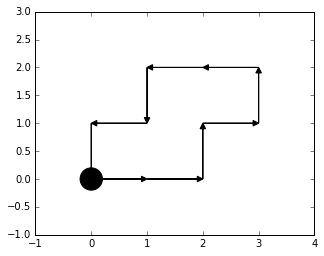

In [17]:
plot_trace(trace_tour(sample_tours[0]))

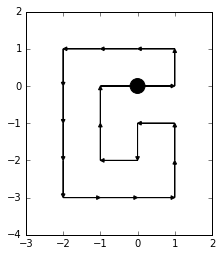

In [37]:
plot_trace(trace_tour(sample_tours[1]))

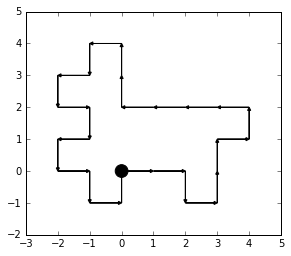

In [38]:
plot_trace(trace_tour(sample_tours[2]))

# Part 1

In [18]:
with open('06-tours.txt') as f:
    tours = [t.strip() for t in f.readlines()]
len(tours)

226

In [19]:
sum(len(t) for t in tours if valid(trace_tour(t)))

61762

In [20]:
sum(1 for t in tours if valid(trace_tour(t)))

100

In [21]:
sum(len(t) for t in tours)

123845

In [22]:
%%timeit
sum(len(t) for t in tours if valid(trace_tour(t)))

10 loops, best of 3: 196 ms per loop


# Part 2

In [23]:
(sum(len(pi + pj)
 for i, pi in enumerate(tours) 
 for j, pj in enumerate(tours)
 if i != j
 if not valid(trace_tour(pi))
 if not valid(trace_tour(pj))
 if valid(trace_tour(pi + pj))) 
 + 
 sum(len(t) for t in tours if valid(trace_tour(t))))

80622

In [24]:
%%timeit
[(i, j) 
 for i, pi in enumerate(tours) 
 for j, pj in enumerate(tours)
 if i != j
 if not valid(trace_tour(pi))
 if not valid(trace_tour(pj))
 if valid(trace_tour(pi + pj))]

1 loop, best of 3: 1min 32s per loop


In [25]:
# [(i, j) 
#  for i, pi in enumerate(tours) 
#  for j, pj in enumerate(tours)
#  if i != j
#  if not valid(trace_tour(pi))
#  if not valid(trace_tour(pj))
#  if valid(trace_tour(pi + pj))]

In [26]:
# (sum(len(t) for t in tours if valid(trace_tour(t)))
#     +
#     sum(len(pi + pj) 
#      for i, pi in enumerate(tours) 
#      for j, pj in enumerate(tours)
#      if i != j
#      if not valid(trace_tour(pi))
#      if not valid(trace_tour(pj))
#      if valid(trace_tour(pi + pj)))
# )

In [27]:
l1s = {}
for t in tours:
    tr = trace_tour(t)
    l1 = abs(tr[-1].x) + abs(tr[-1].y)
    if l1 > 0:
        if l1 not in l1s:
            l1s[l1] = []
        l1s[l1] += [t]

for l1 in l1s:
    if l1 < 20:
        print(l1, len(l1s[l1]))

1 1
2 1
3 4
4 5
5 7
6 3
7 1
8 2
9 2
11 2
18 1
19 1


In [28]:
[(l1, len(l1s[l1])) for l1 in l1s if l1 < 20]

[(1, 1),
 (2, 1),
 (3, 4),
 (4, 5),
 (5, 7),
 (6, 3),
 (7, 1),
 (8, 2),
 (9, 2),
 (11, 2),
 (18, 1),
 (19, 1)]

In [29]:
# %%timeit
# (sum(len(t) for t in tours if valid(trace_tour(t)))
#     +
#     sum(len(pi + pj) 
#      for i, pi in enumerate(tours) 
#      for j, pj in enumerate(tours)
#      if i != j
#      if not valid(trace_tour(pi))
#      if not valid(trace_tour(pj))
#      if valid(trace_tour(pi + pj)))
# )

In [30]:
good_is = []
goods = []
tried = []
for l1 in l1s:
    possible_l1s = [i for i in range(l1-1, l1+1) if i in l1s]
    candidates = [t for i in possible_l1s for t in l1s[i]]
    for t1 in candidates:
        for t2 in candidates:
            if t1 != t2:
                t12 = t1 + t2
                if (t12) not in tried:
                    tried += [(t12)]
                    if valid(trace_tour(t12)):
                        good_is += [(tours.index(t1), tours.index(t2))]
                        goods += [t12]

In [31]:
(sum(len(t) for t in tours if valid(trace_tour(t)))
    +
    sum(len(t12) for t12 in goods)
)

80622

In [32]:
%%timeit

l1s = {}
for t in tours:
    tr = trace_tour(t)
    l1 = abs(tr[-1].x) + abs(tr[-1].y)
    if l1 > 0:
        if l1 not in l1s:
            l1s[l1] = []
        l1s[l1] += [t]

goods = []
tried = []
for l1 in l1s:
    possible_l1s = [i for i in range(l1-1, l1+1) if i in l1s]
    candidates = [t for i in possible_l1s for t in l1s[i]]
    for t1 in candidates:
        for t2 in candidates:
            if t1 != t2:
                t12 = t1 + t2
                if (t12) not in tried:
                    tried += [(t12)]
                    if valid(trace_tour(t12)):
                        goods += [t12]

(sum(len(t) for t in tours if valid(trace_tour(t)))
    +
    sum(len(t12) for t12 in goods)
)

1 loop, best of 3: 1.2 s per loop


In [33]:
len(goods)

13

In [34]:
sorted(good_is)

[(16, 125),
 (70, 48),
 (91, 128),
 (110, 134),
 (116, 194),
 (123, 51),
 (136, 9),
 (142, 193),
 (152, 63),
 (168, 150),
 (201, 83),
 (208, 204),
 (212, 113)]

In [35]:
sorted(good_is, key=lambda p: p[1])

[(136, 9),
 (70, 48),
 (123, 51),
 (152, 63),
 (201, 83),
 (212, 113),
 (16, 125),
 (91, 128),
 (110, 134),
 (168, 150),
 (142, 193),
 (116, 194),
 (208, 204)]

In [36]:
[(l, len(l1s[l])) for l in l1s.keys()]

[(1, 1),
 (2, 1),
 (3, 4),
 (4, 5),
 (5, 7),
 (6, 3),
 (7, 1),
 (8, 2),
 (9, 2),
 (11, 2),
 (18, 1),
 (19, 1),
 (21, 1),
 (24, 1),
 (132, 2),
 (26, 2),
 (28, 1),
 (29, 1),
 (34, 2),
 (36, 1),
 (37, 3),
 (166, 2),
 (40, 2),
 (41, 2),
 (44, 3),
 (46, 1),
 (48, 2),
 (50, 3),
 (52, 2),
 (53, 1),
 (54, 1),
 (56, 2),
 (57, 3),
 (58, 1),
 (59, 2),
 (61, 1),
 (64, 1),
 (66, 2),
 (68, 1),
 (70, 1),
 (74, 1),
 (75, 1),
 (76, 3),
 (77, 1),
 (81, 1),
 (82, 2),
 (86, 1),
 (88, 1),
 (90, 1),
 (94, 1),
 (97, 1),
 (98, 1),
 (101, 2),
 (106, 1),
 (107, 1),
 (114, 2),
 (117, 3),
 (127, 1)]